# Исследование методов построения временных рядов таблиц «затраты-выпуск»

In [33]:
from scripts import support, insd, kuroda, nras, metrics, vectorization as v
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Определение методов, необходимых для проведения анализа

## 1.1. Вспомогательные методы

### 1.1.1. Получение таблиц

In [118]:
def agg_cols_rows(table, cols_to_agg, new_cols, inds_to_agg, new_inds):
    if cols_to_agg is not None:
        for i in range(len(new_cols)):
            table.insert(int(np.argwhere(np.array(table.columns) == cols_to_agg[i][0])[0, 0]), 
                         new_cols[i], np.sum(table[cols_to_agg[i]], axis=1))        
            table = table.drop(columns=cols_to_agg[i])

    if inds_to_agg is not None:
        for i in range(len(new_inds)):
            new_row = pd.Series(np.sum(table.iloc[inds_to_agg[i]], axis=0), name=new_inds[i])
            table = table.append(new_row)
    
        table = table.drop(index=inds_to_agg)
    
    return table        

In [114]:
def read_table(file_name, sheet_name=0, skiprows=None, index_col=None, inds_to_take=None, 
               is_agg=False, cols_to_agg=None, new_cols=None, inds_to_agg=None, new_inds=None):
    
    table = pd.read_excel(file_name, sheet_name, skiprows=skiprows, index_col=index_col)
    
    if inds_to_take is not None:
        table = table.iloc[inds_to_take[0], inds_to_take[1]].astype(np.float)
        
    if is_agg:
        table = agg_cols_rows(table, cols_to_agg, new_cols, inds_to_agg, new_inds)
        
    return table

In [35]:
def get_series_from_df(df, years, inds_to_take):
    tables_shape = (len(inds_to_take), df.shape[1] - 1)
    series = np.zeros((len(years), tables_shape[0], tables_shape[1]), dtype='float')
    
    for i, y in enumerate(years):
        series[i] = df[df['year'] == y].drop(columns='year').iloc[inds_to_take]
        
    return series

### 1.1.2. Проекция таблиц

In [57]:
def apply_classic_method(init_table, true_table, method, sparsed=True, kuroda_args=None, nras_args=None):        
    G = v.addrows(init_table.shape, sparsed=sparsed)
    G = v.addcolumns(init_table.shape, G=G, sparsed=sparsed) 
    
    sums_rows = true_table.sum(axis=1).reshape(-1, 1)
    sums_cols = true_table.sum(axis=0).reshape(-1, 1)
    c = np.append(sums_rows, sums_cols, axis=0)

    vect_a = v.tovector(init_table)
    
    if method == kuroda.kuroda and kuroda_args is not None:
        pred_table = method(G=G, aa=vect_a, c=c, sparsed=sparsed, mtype=kuroda_args['mtype'])
    elif method == nras.nras and nras_args is not None:
        pred_table = method(G=G, aa=vect_a, c=c, sparsed=sparsed, accuracy=nras_args['accuracy'], limit=nras_args['limit'])
    elif method == insd.insd or nras_args is None or kuroda_args is None:
        pred_table = method(G=G, aa=vect_a, c=c, sparsed=sparsed)
    else:
        raise ValueError('Method must be one of [insd.insd, kuroda.kuroda, nras.nras]')
    
    return v.tomatrix(pred_table, shape=init_table.shape)

In [38]:
def predict_tables_classic_method(true_tables, method, sparsed=True, kuroda_args=None, nras_args=None):        
    pred_tables = np.array([], dtype='float').reshape(0, true_tables.shape[1], true_tables.shape[2]) 
    
    pred_table = true_tables[0]
    for i in range(1, len(true_tables)):            
        pred_table = apply_classic_method(pred_table, true_tables[i], 
                                          method, sparsed, kuroda_args, nras_args)        
        pred_tables = np.vstack((pred_tables, [pred_table]))
        
    return pred_tables  

### 1.1.3. Получение результатов

In [39]:
def get_metrics(true_tables, pred_tables, years):
    if len(true_tables) != len(pred_tables) or len(true_tables) != len(years):
        raise ValueError('true_tables, pred_tables and years must have the same length')
    
    for i, y in enumerate(years):
        true_table = true_tables[i]
        pred_table = pred_tables[i]
        
        res_metrics = metrics.get_values(pred_table, true_table, save=True)
        if i == 0:
            metrics_df = pd.DataFrame.from_dict({y: res_metrics}, orient='index')
        else:
            metrics_df = pd.concat((metrics_df, 
                                    pd.DataFrame.from_dict({y: res_metrics}, orient='index')), 
                                    axis=0)
            
    return metrics_df

In [40]:
def plot_metrics(metrics_dfs, methods_names):
    metrics_names = list(metrics_dfs[0].keys())
    fig, ax = plt.subplots(2, 3, figsize=(15, 10)) 
    
    ind = 0
    for i in range(ax.shape[0]):    
        for j in range(ax.shape[1]):      
            
            for method_name, metrics_df in zip(methods_names, metrics_dfs):
                if metrics_names[ind] not in metrics_df.columns:
                    continue
                    
                if metrics_df.shape[0] == 1:
                    ax[i, j].scatter(metrics_df.index[0], metrics_df[metrics_names[ind]], label=method_name)
                else:
                    ax[i, j].plot(metrics_df[metrics_names[ind]], marker='o', label=method_name)

            ax[i, j].set_title(metrics_names[ind])
            ax[i, j].legend()
            ax[i, j].grid(True)
            
            ind += 1

    plt.show()

## 1.2. Исследуемые методы

### 1.2.1. Cycling method (Lenzen et al., 2012)

$alpha = 1 \Rightarrow$ the initial estimate is always and only taken from the same-year solution of the prior cycle

$alpha = 0 \Rightarrow$ the initial estimate ignores any prior cycle and only ever considers same-cycle, prior-year values

In [76]:
def cycling_method(true_tables, method, max_cycles, is_forecast=True, alpha=0.5, eps=0.01,
                   sparsed=True, kuroda_args=None, nras_args=None):    
    
    if not is_forecast:
        true_tables = np.flip(true_tables, axis=0)
    
    a = np.zeros((2, true_tables.shape[0], true_tables.shape[1], true_tables.shape[2]), dtype='float')
    a[0, 1:-1] = predict_tables_classic_method(true_tables[:-1], method, sparsed, kuroda_args, nras_args)
    a[:, 0] = np.array([true_tables[0], true_tables[0]])
    a[:, -1] = np.array([true_tables[-1], true_tables[-1]])
    
#     a = np.expand_dims(np.zeros_like(true_tables), 0)
#     a[0, 1:-1] = predict_tables_classic_method(true_tables[:-1], method, sparsed, kuroda_args, nras_args)
#     a[0, 0] = true_tables[0]
#     a[0, -1] = true_tables[-1]
        
    w = np.array([[0, alpha], [1 - alpha, 0]])    
    
    y = len(true_tables) - 1
    for c in range(1, max_cycles):
        
#         a_c = np.expand_dims(np.zeros_like(true_tables), 0)
#         a_c[0, 0] = true_tables[0]
#         a_c[0, -1] = true_tables[-1]
#         a = np.vstack((a, a_c))
        
        for i in range(len(true_tables) - 2):
            increment = 1 if c % 2 == 0 else -1
            y = y + increment
            init_table = w[0, 1] * a[1, y - increment] + w[1, 0] * a[0, y] 
#             init_table = w[0, 1] * a[c, y - increment] + w[1, 0] * a[c - 1, y]

#             a[c, y] = apply_classic_method(init_table, true_tables[y], method, sparsed, kuroda_args, nras_args) 
            a[1, y] = apply_classic_method(init_table, true_tables[y], method, sparsed, kuroda_args, nras_args) 

#         a_avg = np.average(a[-2:], axis=0)  
        a_avg = np.average(a, axis=0)
#         if np.average(np.abs(a[c] - a[c - 1]) / a[c - 1]) < eps or c == max_cycles - 1:
        if np.average(np.abs(a[1] - a_avg) / a_avg) < eps or c == max_cycles - 1:
            print('final cycle:', c + 1)
            break
            
        a[0] = a[1]        
        y = y + increment
        
    return a_avg if is_forecast else np.flip(a_avg, axis=0)

### 1.2.2. MTT method (Wang et al, 2015)

#### 1.2.2.1. Classic MTT

In [42]:
def transform_mtt0(x_arr):    
    y_arr = np.zeros_like(x_arr, dtype='float')
    
    for i in range(x_arr.shape[0]):
        z = x_arr[i, :-1, :-1]
        f = x_arr[i, :-1, -1]
        v = x_arr[i, -1, :-1]
        mu = np.sum(v)
        
        t = np.linalg.inv(np.diag(f)) @ z
        d = v / mu
        
        y_arr[i, :-1, :-1] = t
        y_arr[i, -1, :-1] = d
        y_arr[i, :, -1] = np.ones(y_arr[0].shape[0])
    
    return y_arr

In [43]:
def inv_transform_mtt0(y_arr, mu_arr):
    x_arr = np.zeros_like(y_arr, dtype='float')
    x_arr[:, -1, -1] = mu_arr
    
    for i in range(y_arr.shape[0]):
        t = y_arr[i, :-1, :-1]
        d = y_arr[i, -1, :-1]
        
        v = mu_arr[i] * d
        b = np.diag(np.sum(t, axis=1) + np.ones(t.shape[0])) - np.transpose(t)
        f = np.linalg.inv(b) @ v
        z = np.diag(f) @ t
        
        x_arr[i, :-1, :-1] = z
        x_arr[i, -1, :-1] = v
        x_arr[i, :-1, -1] = f
                           
    return x_arr

#### 1.2.2.2. MTT I - zeros in final demand

In [44]:
def transform_mtt1(x_arr):    
    y_arr = np.zeros_like(x_arr, dtype='float')
    
    for i in range(x_arr.shape[0]):
        z = x_arr[i, :-1, :-2]
        f1 = x_arr[i, :-1, -2]
        f2 = x_arr[i, :-1, -1]
        v = x_arr[i, -1, :-2]
        mu1 = np.sum(f1)
        mu2 = np.sum(f2)
        
        f2_inv = np.linalg.inv(np.diag(f2))
        t = f2_inv @ z
        d = v / mu2
        p = f2_inv @ f1
        lam = mu1 / mu2
        
        y_arr[i, :-1, :-2] = t
        y_arr[i, -1, :-2] = d
        y_arr[i, :-1, -1] = p
        y_arr[i, -1, -1] = lam
        y_arr[i, :, -1] = np.ones(y_arr[0].shape[0])
    
    return y_arr

In [45]:
def inv_transform_mtt1(y_arr, f1_arr, mu2_arr):
    x_arr = np.zeros_like(y_arr, dtype='float')
    x_arr[:, :-1, -2] = f1_arr
    x_arr[:, -1, -1] = mu2_arr
    
    for i in range(y_arr.shape[0]):
        t = y_arr[i, :-1, :-2]
        d = y_arr[i, -1, :-2]
        p = y_arr[i, :-1, -1]
        lam = y_arr[i, -1, -1]
        
        v = mu2_arr[i] * d
        b = np.diag(np.sum(t, axis=1) + np.ones(t.shape[0])) - np.transpose(t)
        f2 = np.linalg.inv(b) @ (v - f1_arr[i])
        z = np.diag(f2) @ t
        mu1 = np.sum(f1_arr[i])
        
        x_arr[i, :-1, :-2] = z
        x_arr[i, -1, :-2] = v
        x_arr[i, :-1, -1] = f2
        x_arr[i, -1, -2] = mu1
                           
    return x_arr

#### 1.2.2.3. MTT II - constraints known

In [46]:
def transform_mtt2(z_arr):    
    if 0 in z_arr[:, :, :-1]:
        raise ValueError('there should not be zeros in the last column of z')
        
    return z_arr[:, :-1, :-1] / z_arr[:, :-1, -1:]      

In [47]:
def inv_transform_mtt2(u_arr, gross_out, int_out, int_in):
    x_arr = np.zeros((u_arr.shape[0], u_arr.shape[1] + 2, u_arr.shape[2] + 2), dtype='float')
    
    for i in range(u_arr.shape[0]):
        for j in range(u_arr.shape[1]):
            x_arr[i, j, :-2] = u_arr[i, j] * int_in[i, j] / (1 + np.sum(u_arr[i, j]))
            x_arr[i, j, -2] = int_in[i, j] / (1 + np.sum(u_arr[i, j]))
        
        x_arr[i, -2, :-1] = int_out[i] - np.sum(x_arr[i], axis=0)
        
    x_arr[:, -1, :-1] = gross_out - int_out
    x_arr[:, :-1, -1] = gross_out - int_in
    
    return x_arr

In [48]:
mtt_types = dict(zip([0, 1, 2], [('mtt 0', transform_mtt0, inv_transform_mtt0),
                                 ('mtt i', transform_mtt1, inv_transform_mtt2),
                                 ('mtt ii', transform_mtt2, inv_transform_mtt2)]))

In [49]:
def mtt(true_tables, n_base_years, model_inst, mtype=0):
    if 0 in true_tables[:, :-1, -1]:
        mtype = 1
        
    print('using', mtt_types[mtype][0])
    transform_mtt = mtt_types[mtype][1]
    inv_transform_mtt = mtt_types[mtype][2]
    
    y_base = transform_mtt(true_tables_arr[:n_base_years])
    y_pred = np.zeros((len(true_tables) - n_base_years, true_tables[0].shape[1], true_tables[0].shape[2]), dtype='float')
    
    f = model_inst    
    for i in range(f_arr.shape[0]):
        for j in range(f_arr.shape[1]):
            x = np.arange(1, n_base_years + 1, 1, dtype='float').reshape(n_base_years, 1)
            y = y_base[:n_base_years, i, j].reshape(n_base_years, 1)
            f[i, j].fit(x, y)
            
            y_pred[:, i, j] = f[i, j].predict(np.arange(len(y_pred)))
       
    if mtype == 0:
        return inv_transform_mtt(y_pred, mu_arr=true_tables[n_base_years:, -1, -1])
    
    elif mtype == 1:
        f1_arr = true_tables[n_base_years:, :-1, -2]
        mu2_arr = np.sum(true_tables[n_base_years:, :-1, -1])
        return inv_transform_mtt(y_pred, f1_arr, mu2_arr)
    
    elif mtype == 2:
        gross_out = np.sum(true_tables[:, :-1], axis=2)
        int_out = np.sum(true_tables[:, :-1, :-1], axis=1)
        int_in = np.sum(true_tables[:, :-1, :-1], axis=2)

# 2. Тест

In [85]:
def apply_methods(true_tables, max_cycles=10):
    methods = [nras.nras, insd.insd, kuroda.kuroda]
    
    method_names = ['nras', 'insd', 'kuroda']
    variations_names = ['simple', 'series', 'cycling forecast', 'cycling backcast']
    method_variations_names = [m + ' ' + v for m in method_names for v in variations_names]

    metrics_vals = dict.fromkeys(method_variations_names)

    for i, method in enumerate(methods):
        metrics_vals[method_variations_names[i * 4]] = get_metrics([true_tables[-1]], 
                                                                   [apply_classic_method(true_tables[0], true_tables[-1], method)], 
                                                                   [years[-1]])
        print(method_variations_names[i * 4])

        metrics_vals[method_variations_names[i * 4 + 1]] = get_metrics(true_tables[1:], 
                                                                       predict_tables_classic_method(true_tables, method), 
                                                                       years[1:])
        print(method_variations_names[i * 4 + 1])

        metrics_vals[method_variations_names[i * 4 + 2]] = get_metrics(true_tables[1:-1], 
                                                                       cycling_method(true_tables, method, max_cycles=max_cycles, is_forecast=True)[1:-1], 
                                                                       years[1:-1])
        print(method_variations_names[i * 4 + 2])

        metrics_vals[method_variations_names[i * 4 + 3]] = get_metrics(true_tables[1:-1], 
                                                                       cycling_method(true_tables, method, max_cycles=max_cycles, is_forecast=False)[1:-1], 
                                                                       years[1:-1])
        print(method_variations_names[i * 4 + 3])
        
        plot_metrics([metrics_vals[mn] for mn in method_variations_names[i * 4 : i * 4 + len(variations_names)]],
                     method_variations_names[i * 4 : i * 4 + len(variations_names)])
        
    return metrics_vals

In [86]:
import scipy.stats as ss

In [87]:
def get_compared_results(metrics_vals):
    method_names = list(metrics_vals.keys())
    metrics_names = list(list(metrics_vals.values())[0].columns)
    ranks_names = [mn + '_R' for mn in metrics_names[1:]]

    columns_names = [metrics_names[0]]
    for metric_name, rank_name in zip(metrics_names[1:], ranks_names):
        columns_names.extend([metric_name, rank_name])
    columns_names.extend(['R_all', 'CmR'])

    metrics_comp_df = pd.DataFrame(data=np.zeros((len(method_names), len(columns_names)), dtype='float'),
                                   index=method_names, 
                                   columns=columns_names)

    for method_name, metrics_vals in metrics_vals.items():
        metrics_comp_df.loc[method_name, metrics_names] = np.average(metrics_vals, axis=0)

    for i in range(len(ranks_names)):
        metrics_comp_df[ranks_names[i]] = ss.rankdata(metrics_comp_df[metrics_names[i + 1]] 
                                                      if metrics_names[i + 1] != 'RSQ' 
                                                      else -metrics_comp_df[metrics_names[i + 1]], 'min')

    metrics_comp_df['R_all'] = metrics_comp_df[ranks_names].sum(axis=1)
    metrics_comp_df['CmR'] = ss.rankdata(metrics_comp_df['R_all'], 'min')

    metrics_comp_df = metrics_comp_df.sort_values('CmR')
                        
    return metrics_comp_df

## Россия 2011-2016

In [88]:
rus_years = np.arange(2011, 2017)

### Таблицы ресурсов - I квадрант

In [89]:
rus_11_16_st = []
for y in rus_years:
    rus_11_16_st.append(read_table('./data/tri-' + str(y) + '.xlsx', sheet_name='ТР', 
                                   skiprows=2, index_col=1, inds_to_take=[np.arange(1, 62), np.arange(2, 61)]).values)
    print(y, rus_11_16_st[-1].shape)    
rus_11_16_st = np.array(rus_11_16_st)

2011 (61, 59)
2012 (61, 59)
2013 (61, 59)
2014 (61, 59)
2015 (61, 59)
2016 (61, 59)


nras simple
nras series
final cycle: 10
nras cycling forecast
final cycle: 10
nras cycling backcast


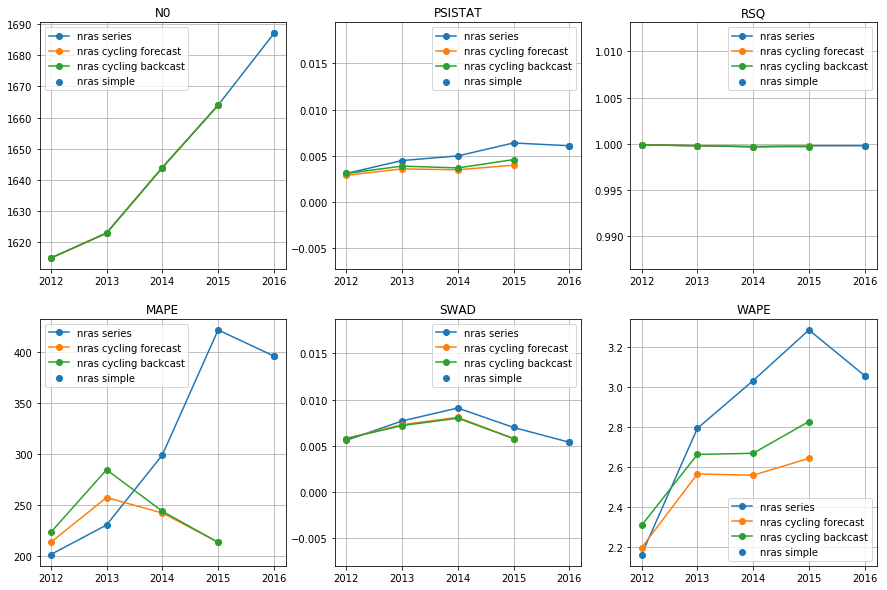


--------------------------------------------
--------------------------------------------

Using license file C:\Users\Asus\gurobi.lic
Academic license - for non-commercial use only
insd simple
insd series
final cycle: 10
insd cycling forecast
final cycle: 10
insd cycling backcast


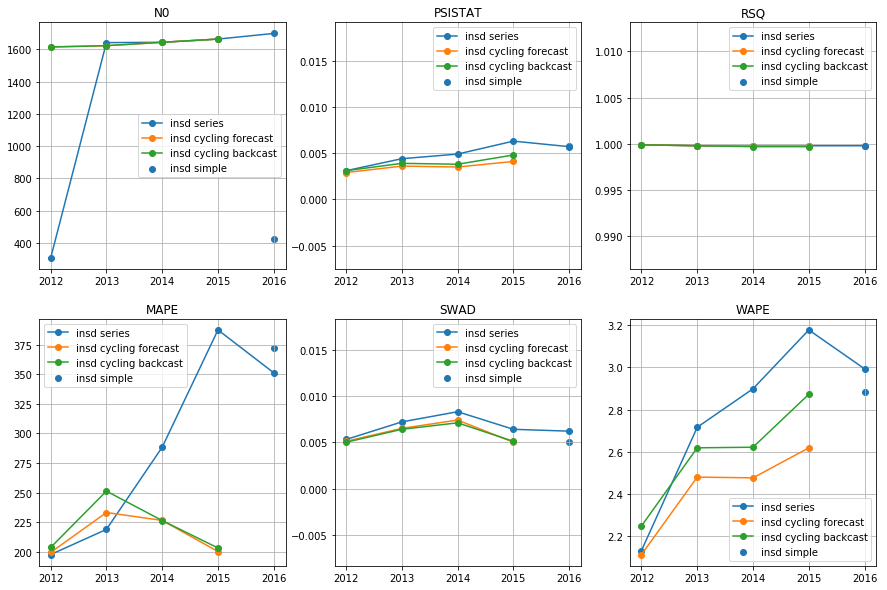

kuroda simple
kuroda series
final cycle: 10
kuroda cycling forecast
final cycle: 10
kuroda cycling backcast


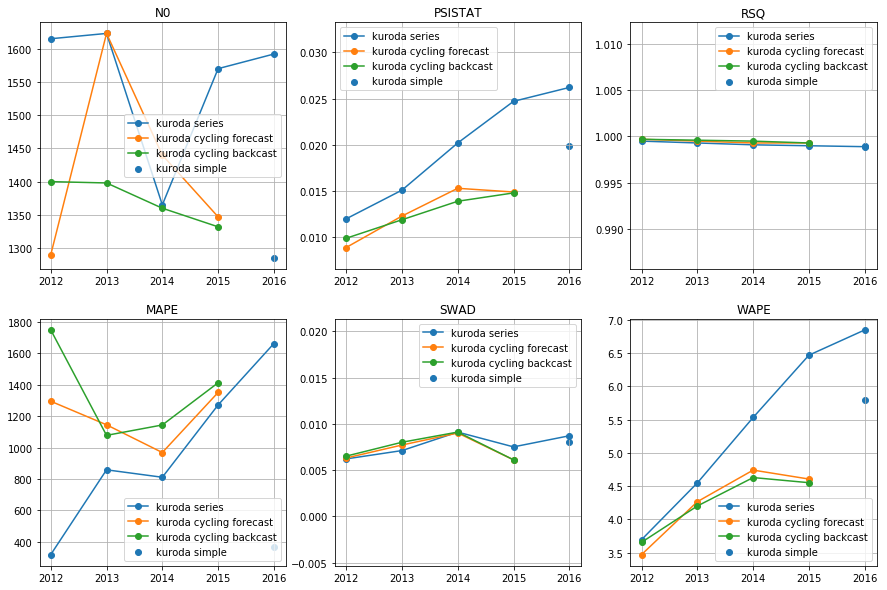

In [90]:
rus_11_16_st_metrics_vals = apply_methods(rus_11_16_st)

In [92]:
get_compared_results(rus_11_16_st_metrics_vals)

,N0,PSISTAT,PSISTAT_R,RSQ,RSQ_R,MAPE,MAPE_R,SWAD,SWAD_R,WAPE,WAPE_R,R_all,CmR
insd cycling forecast,1636.5,0.003525,2,0.999825,1,214.769950,1,0.006000,4,2.421275,1,9,1
nras cycling forecast,1636.5,0.003500,1,0.999800,4,231.928450,3,0.006750,7,2.492600,2,17,2
insd cycling backcast,1636.5,0.003900,4,0.999775,7,221.061400,2,0.005900,3,2.589850,3,19,3
insd series,1390.8,0.004880,5,0.999820,2,288.644320,5,0.006680,5,2.783160,5,22,4
nras cycling backcast,1636.5,0.003825,3,0.999775,7,241.521650,4,0.006700,6,2.618050,4,24,5
insd simple,424.0,0.005800,7,0.999800,4,371.985600,8,0.005000,1,2.883100,7,27,6
nras series,1646.6,0.005020,6,0.999800,3,309.796900,6,0.006960,8,2.866740,6,29,7
nras simple,1687.0,0.006100,8,0.999800,4,395.945200,9,0.005400,2,3.057800,8,31,8
kuroda cycling backcast,1372.5,0.012625,9,0.999525,9,1345.219225,12,0.007425,10,4.258200,9,49,9
kuroda cycling forecast,1425.0,0.012850,10,0.999450,10,1189.477400,11,0.007275,9,4.270000,10,50,10


### Таблицы использования в основных ценах - I квадрант

#### I квадрант

In [93]:
rus_11_16_uti = []
for y in rus_years:
    rus_11_16_uti.append(read_table('./data/tri-' + str(y) + '.xlsx', sheet_name='ТИоц', 
                                   skiprows=2, index_col=1, inds_to_take=[np.arange(1, 63), np.arange(2, 61)]).values)
    print(y, rus_11_16_uti[-1].shape)    
rus_11_16_uti = np.array(rus_11_16_uti)

2011 (62, 59)
2012 (62, 59)
2013 (62, 59)
2014 (62, 59)
2015 (62, 59)
2016 (62, 59)


nras simple
nras series
final cycle: 10
nras cycling forecast
final cycle: 10
nras cycling backcast


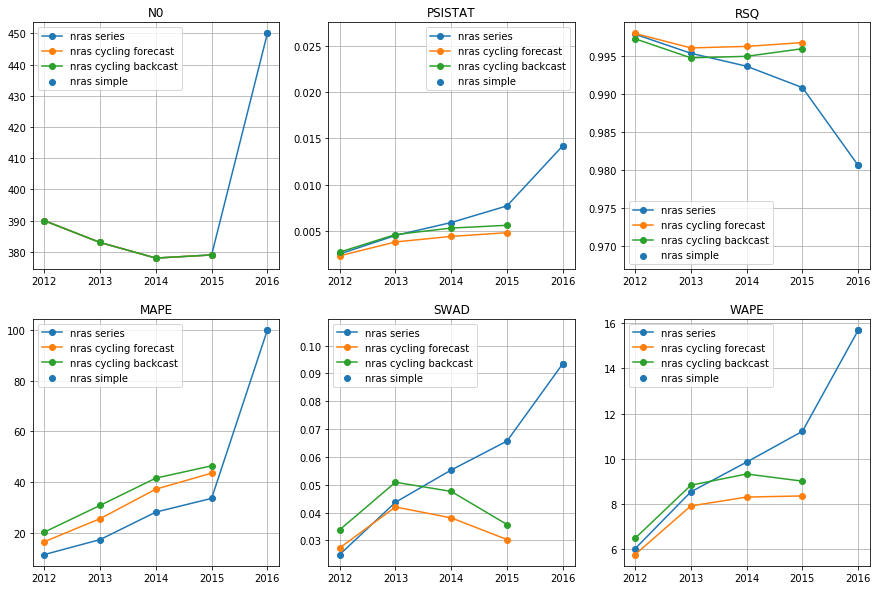

insd simple
insd series
final cycle: 10
insd cycling forecast
final cycle: 10
insd cycling backcast


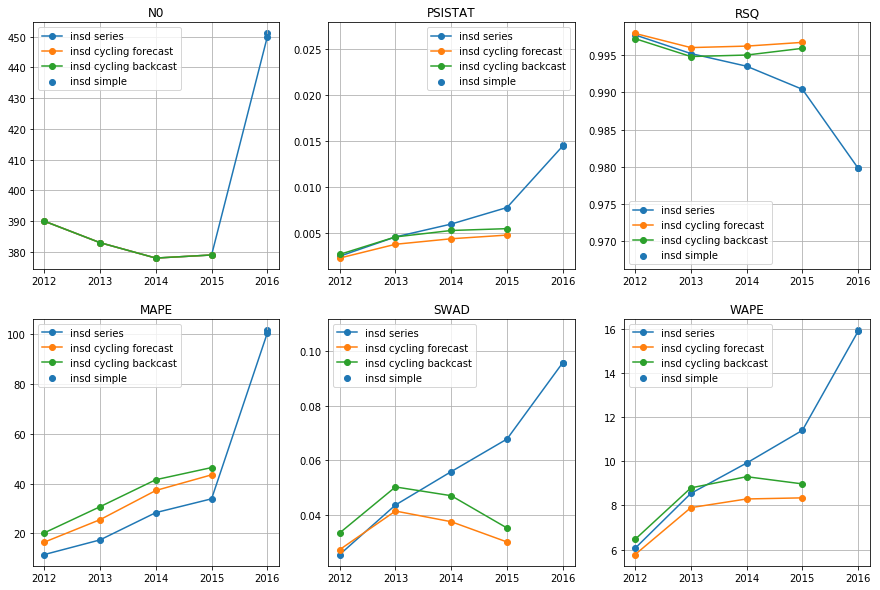

kuroda simple
kuroda series
final cycle: 10
kuroda cycling forecast
final cycle: 10
kuroda cycling backcast


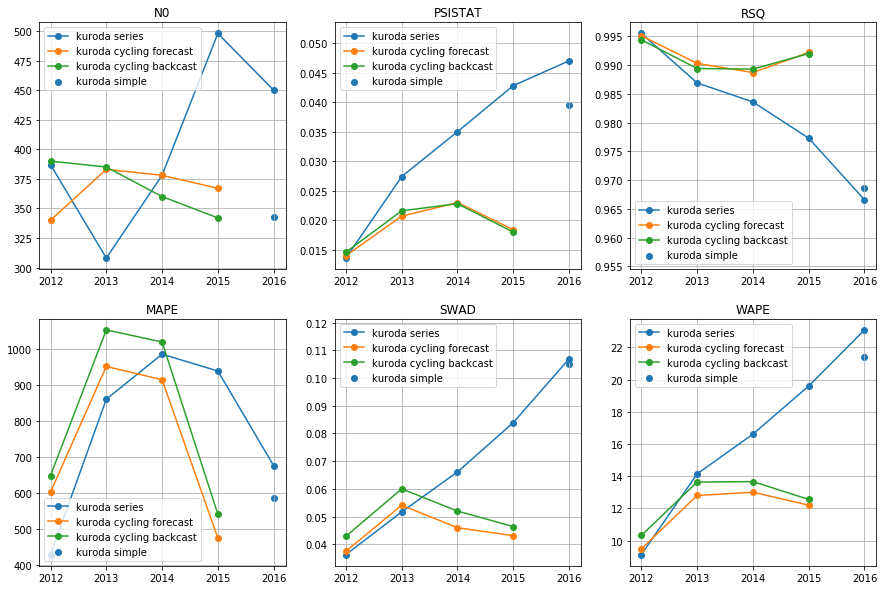

In [94]:
rus_11_16_uti_metrics_vals = apply_methods(rus_11_16_uti)

In [95]:
get_compared_results(rus_11_16_uti_metrics_vals)

,N0,PSISTAT,PSISTAT_R,RSQ,RSQ_R,MAPE,MAPE_R,SWAD,SWAD_R,WAPE,WAPE_R,R_all,CmR
insd cycling forecast,382.50,0.003825,1,0.996700,1,30.715750,2,0.034175,1,7.577925,1,6,1
nras cycling forecast,382.50,0.003825,1,0.996700,1,30.679975,1,0.034425,2,7.579925,2,7,2
insd cycling backcast,382.50,0.004525,3,0.995725,3,34.768875,4,0.041550,3,8.385875,3,16,3
nras cycling backcast,382.50,0.004550,4,0.995675,4,34.753800,3,0.042000,4,8.408300,4,19,4
nras series,396.00,0.006960,5,0.991620,5,38.084740,5,0.056620,7,10.260420,5,27,5
insd series,396.00,0.007080,6,0.991320,7,38.375080,6,0.057740,8,10.371600,6,33,6
kuroda cycling forecast,367.00,0.019025,9,0.991575,6,735.060675,10,0.045175,5,11.878300,7,37,7
nras simple,450.00,0.014200,7,0.980600,10,100.021500,7,0.093500,10,15.690300,9,43,8
kuroda cycling backcast,369.25,0.019250,10,0.991275,8,814.648875,12,0.050325,6,12.549850,8,44,9
insd simple,451.00,0.014600,8,0.979900,11,101.819700,8,0.095500,11,15.957200,10,48,10


#### I и II квадрант

In [126]:
rus_11_16_utii = []
for y in rus_years:
    if y in [2011, 2016]:
        rus_11_16_utii.append(read_table('./data/tri-' + str(y) + '.xlsx', sheet_name='ТИоц', 
                                         skiprows=2, index_col=1,
                                         inds_to_take=[np.arange(1, 62), 
                                                       np.append(np.arange(2, 61), [62, 63, 64, 65, 67, 68, 69, 71])],
                                         is_agg=True, 
                                         cols_to_agg=[['P31_S13', 'P32_S13'], ['P51', 'P53']], new_cols=['P3_S13', 'P51+P53']).values)
    else:
        rus_11_16_utii.append(read_table('./data/tri-' + str(y) + '.xlsx', sheet_name='ТИоц', 
                                         skiprows=2, index_col=1,
                                         inds_to_take=[np.arange(1, 62), 
                                                       np.append(np.arange(2, 61), [62, 63, 64, 66, 67, 69])]).values)
    
    print(y, rus_11_16_utii[-1].shape)  
    
rus_11_16_utii = np.array(rus_11_16_utii)

2011 (61, 65)
2012 (61, 65)
2013 (61, 65)
2014 (61, 65)
2015 (61, 65)
2016 (61, 65)


nras simple
nras series
final cycle: 10
nras cycling forecast
final cycle: 10
nras cycling backcast


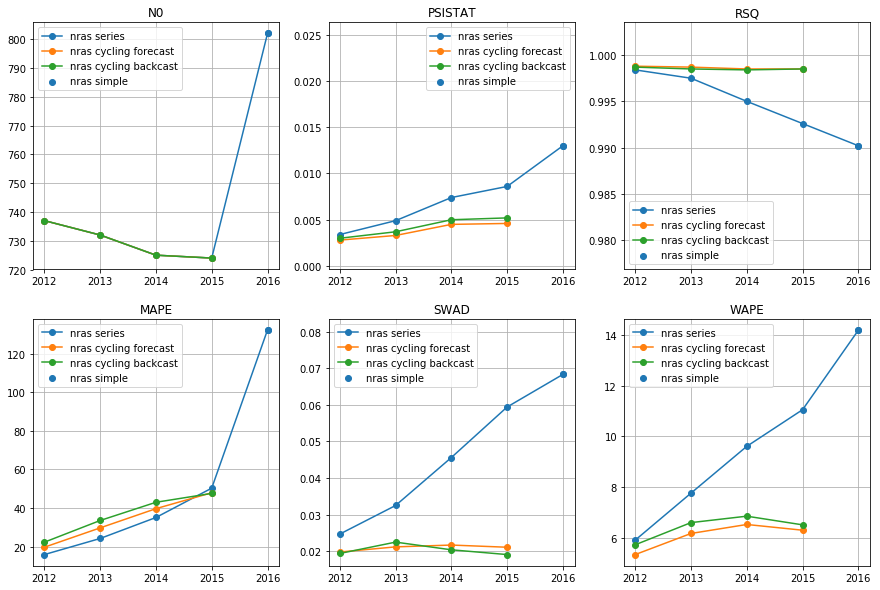

insd simple
insd series
final cycle: 10
insd cycling forecast
final cycle: 10
insd cycling backcast


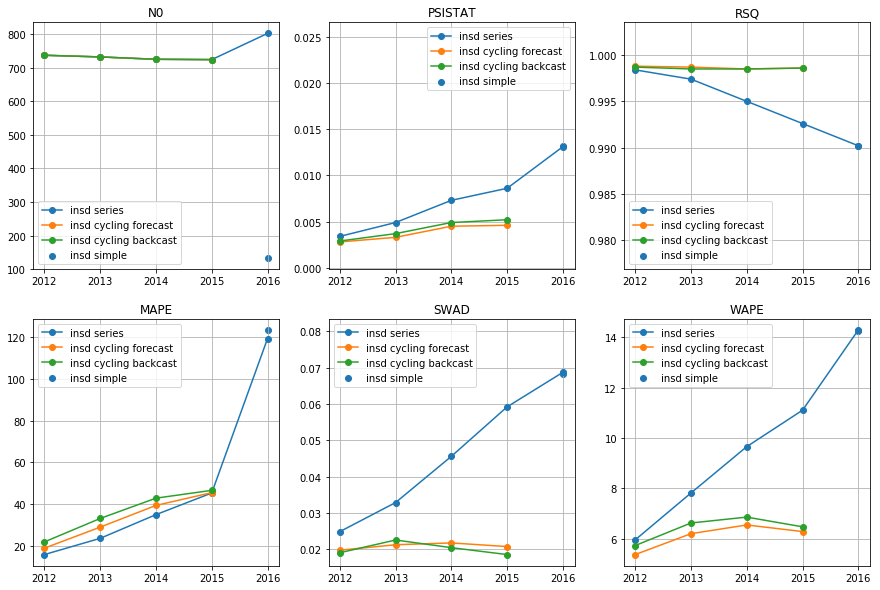

kuroda simple
kuroda series
final cycle: 10
kuroda cycling forecast
final cycle: 10
kuroda cycling backcast


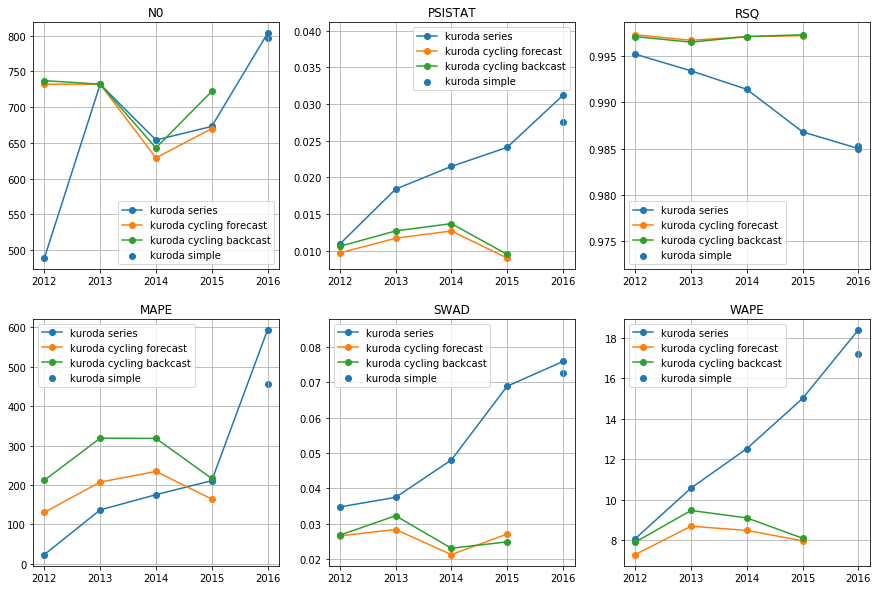

In [127]:
rus_11_16_utii_metrics_vals = apply_methods(rus_11_16_utii)

In [128]:
get_compared_results(rus_11_16_utii_metrics_vals)

,N0,PSISTAT,PSISTAT_R,RSQ,RSQ_R,MAPE,MAPE_R,SWAD,SWAD_R,WAPE,WAPE_R,R_all,CmR
insd cycling forecast,729.50,0.003800,1,0.998650,1,33.210600,1,0.020925,3,6.103325,2,8,1
nras cycling forecast,729.50,0.003800,1,0.998625,2,34.288000,2,0.020950,4,6.101850,1,10,2
insd cycling backcast,729.50,0.004175,3,0.998575,3,36.145275,3,0.020200,1,6.424100,3,13,3
nras cycling backcast,729.50,0.004225,4,0.998525,4,36.633525,4,0.020350,2,6.438850,4,18,4
kuroda cycling forecast,690.75,0.010775,7,0.997075,5,184.288075,9,0.025750,5,8.107525,5,31,5
nras series,744.00,0.007460,5,0.994740,7,51.581100,6,0.046100,7,9.706780,7,32,6
insd series,744.00,0.007460,5,0.994720,8,47.836960,5,0.046260,8,9.765400,8,34,7
kuroda cycling backcast,708.50,0.011625,8,0.997000,6,266.342175,11,0.026675,6,8.641350,6,37,8
nras simple,802.00,0.013000,9,0.990200,10,132.255600,8,0.068300,11,14.172600,10,48,9
insd simple,133.00,0.013200,10,0.990200,10,123.522600,7,0.068200,10,14.233900,11,48,9


### Симметричные таблицы